# Conditionally Risk-Averse Contextual Bandits Quick Start

In this notebook we simulate a simple product selling scenario. 

The algorithm must choose the product quality (from 1 to 10) based on the product features (context). If the chosen quality is equal or lower than the ground truth value, we can sell the product and can get a maximum reward (1) but have to pay the expenses of the difference between the predicted and the actual quality; if the algorithm chooses higher quality than the true quality, we cannot sell the product and receive 0 reward.

At the end, we show the trade-off between the **risk-averse** algorithm which avoids low rewards but achieves a slightly worse average performance and the **risk-neutral** algorithm that gets better average results but results in degraded worst-case performance. 



In [ ]:
!pip install vowpalwabbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the neccessary packages
import vowpalwabbit
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import numpy as np

In [ ]:
random.seed(42)

# Simulate reward

In our simulation we need to generate a context and a reward (actions are fixed for each context).

The context in this case is two categorical features of the product: its brand and the year it was produced. The goal is to predict the quality (from 1 to 10) of the product, by taking an action (1-10). For each brand-year combination we generate a true label (1-10), which will be compared with the chosen action. Based on the predicted and the true quality, we receive a reward.

In [ ]:
def get_cost(context, chosen_action):
  if context["brand"] == "a":
    if context["year"] == "2000":
      label = random.randint(1, 3)
    elif context["year"] == "2010":
      label = random.randint(4, 6)
    elif context["year"] == "2020":
      if random.random()<0.75:
        label = random.randint(7, 8)
      else:
        label = random.randint(1, 2)
      
  elif context["brand"] == "b":
    if context["year"] == "2000":
      label = random.randint(3, 5)
    elif context["year"] == "2010":
      label = random.randint(6, 8)
    elif context["year"] == "2020":
      if random.random()<0.75:
        label = random.randint(9, 10)
      else:
        label = random.randint(1, 2)

  # if the predicted quality (chosen action) is below the true quality (label) we can sell the product and can get a maximum reward (1) but have to pay the expenses of the difference between the predicted and the actual quality
  # overestimating the quality gives 0 reward
  if chosen_action<=label:
    # VW minimizes loss/cost, therefore we will pass cost as -reward
    return -(1-0.1*(label-chosen_action))
  return 0

# VW format

For using VW, we need to create a compatible format.

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |Product brand={}:1 year={}:1\n".format(
        context["brand"], context["year"]
    )
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action quality:{} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

In [ ]:
# Print an example of product brand "a" from 2010
context = {"brand":"a", "year":"2010"}
actions = list(range(0,11))

print(to_vw_example_format(context, actions))

shared |Product brand=a:1 year=2010:1
|Action quality:0 
|Action quality:1 
|Action quality:2 
|Action quality:3 
|Action quality:4 
|Action quality:5 
|Action quality:6 
|Action quality:7 
|Action quality:8 
|Action quality:9 
|Action quality:10 


# Getting a decision

By passing an example to VW, it returns a probability mass function, from which we can sample an action and get its probability.

In [ ]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [ ]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

# Simulation set up

We will choose our context (brand and year) uniformly at random.

In [ ]:
brands = ["a", "b"]
years = ["2000", "2010", "2020"]
actions = list(range(1,11))

def choose_brand(brands):
    return random.choice(brands)

def choose_year(years):
    return random.choice(years)

After choosing the brand and the year, we pass the context to the VW learner to get an action and its probability. We also get the cost of choosing this action. Finally, the VW learner can learn from this example after formatting it in VW format.

In [ ]:
def run_simulation(
    vw, num_iterations, brand, year, actions, cost_function, do_learn=True
):
    cost_sum = 0.0
    reward_rate = []
    rewards = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a brand
        brand = choose_brand(brands)
        # 2. Choose year for a given product
        year = choose_year(years)

        # 3. Pass context to vw to get an action
        context = {"brand": brand, "year": year}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(
                to_vw_example_format(context, actions, (action, cost, prob)),
                vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
            )
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know we're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        reward_rate.append(-1 * cost_sum / i)
        rewards.append(-cost)

    return reward_rate, rewards

We can plot the reward rate (reward = -cost) over the iterations.

In [ ]:
def plot_reward_rate(num_iterations, reward_rate):
    plt.show()
    plt.plot(range(1, num_iterations + 1), reward_rate)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("reward rate", fontsize=14)

## Running a risk-averse learner with expectile parameter q=0.2

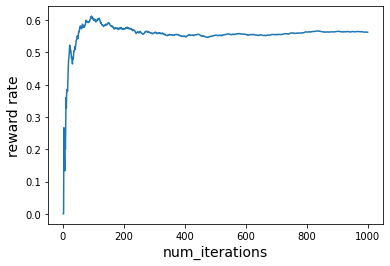

In [ ]:
gamma_scale = 1000  # SquareCB greediness parameter to gamma=[gamma_scale]*[num examples]^[gamma_exponent]
gamma_exponent = 0.8 # Exponent on [num examples] in SquareCB greediness parameter gamma
expectile_q = 0.2 # Parameter q associated with Expectile loss

# Instantiate learner in VW
vw = vowpalwabbit.Workspace("--cb_explore_adf -q :: --cb_type mtr --squarecb --gamma_scale "
  + str(gamma_scale) 
  + " --gamma_exponent "
  + str(gamma_exponent)
  + " --loss_function expectile --expectile_q "
  + str(expectile_q))

# Run simulation
num_iterations = 1000
reward_rate_q20, rewards_q20 = run_simulation(vw, num_iterations, brands, years, actions, get_cost)
vw.finish()

# Plot reward rate over iterations
plot_reward_rate(num_iterations, reward_rate_q20)

## Running a risk-neutral learner with expectile parameter q=0.5 

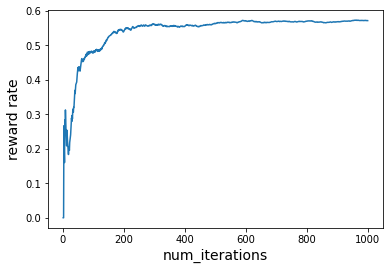

In [ ]:
gamma_scale = 1000  # SquareCB greediness parameter to gamma=[gamma_scale]*[num examples]^[gamma_exponent]
gamma_exponent = 0.8 # Exponent on [num examples] in SquareCB greediness parameter gamma
expectile_q = 0.5 # Parameter q associated with Expectile loss

# Instantiate learner in VW
vw = vowpalwabbit.Workspace("--cb_explore_adf -q :: --cb_type mtr --squarecb --gamma_scale "
  + str(gamma_scale) 
  + " --gamma_exponent "
  + str(gamma_exponent)
  + " --loss_function expectile --expectile_q "
  + str(expectile_q))

# Run simulation
num_iterations = 1000
reward_rate_q50, rewards_q50 = run_simulation(vw, num_iterations, brands, years, actions, get_cost)
vw.finish()

# Plot reward rate over iterations
plot_reward_rate(num_iterations, reward_rate_q50)

# Visualize evaluation expectile

We want to plot the trade-off between tail control and average-case performance.


The **risk-averse learner** (with q=0.2) achieves better tail performance but lower average performance. In contrast to this, the **risk-neutral learner** (with q=0.5) suffers from degraded worst-case behaviour in exchange for better average-case results. 

If our goal is to avoid bad outcomes, the risk-averse approach is clearly the better choice.

In [ ]:
# Expectile loss
def f(m, *data):
   q, x = data
   return q * np.sum(np.square(np.clip(x - m, a_min=0, a_max=None))) + (1 - q) * np.sum(np.square(np.clip(x - m, a_min=None, a_max=0)))

In [ ]:
# Calculate EVaR = the minimizer of the expectile loss
def calc_evar(rew, q=0.2, bounds=(-1,1)):
  data = (q, rew)
  return float(minimize_scalar(f, bounds=bounds, method='bounded', args=data).x)

In [ ]:
# Evaluation expectile values, used for plotting
eval_expectiles_w = [0.1,0.2,0.3,0.4,0.5]

In [ ]:
# Calculate the the evaluation EVaR values of the risk-averse learner
evars_q20 = []
for w in eval_expectiles_w:
  evar_q20 = calc_evar(rewards_q20, q=w, bounds=(0,1)) 
  evars_q20.append(evar_q20)

In [ ]:
# Calculate the the evaluation EVaR values of the risk-neutral learner
evars_q50 = []
for w in eval_expectiles_w:
  evar_q50 = calc_evar(rewards_q50, q=w, bounds=(0,1)) 
  evars_q50.append(evar_q50)

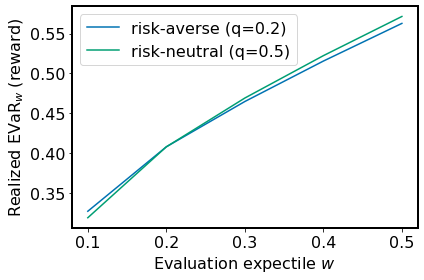

In [ ]:
plt.style.use('seaborn-colorblind')
plt.plot(eval_expectiles_w, evars_q20, label='risk-averse (q=0.2)') # Plot the risk-averse learner
plt.plot(eval_expectiles_w, evars_q50, label='risk-neutral (q=0.5)') # Plot the risk-neutral learner

plt.xlabel('Evaluation expectile $w$', fontsize=16) # 5 different evaluation expectiles where we calculated the EVaR values
plt.ylabel('Realized EVaR$_w$ (reward)', fontsize=16) # EVaR values, the higher the better

plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=5)

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.setp(plt.gca().spines.values(), linewidth=2)
plt.tight_layout()